Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

## Setup

In [20]:
import numpy as np
from numpy.linalg import eig
import matplotlib
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple

In [21]:
# constants
# MESH
n_spatial_locs = 11  # define number of grid points along 1D line

# IMPULSE INPUT
#particle_start_loc = 5  # starting position for molecules
#particle_start_loc = 3  # starting position for molecules

min_loc = 0             # minimum position
max_loc = n_spatial_locs - 1  # maximum position
last_elem_i = -1        # index for the last element in a list 


# SIMULATION
dt = 1                  # time step (usec)
n_time_pts = 1000       # number of time points
line_length = 4         # total length of diffusion line (um)
n_particles = 50        # number of molecules
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

### Disable Scrolling Cells

In [22]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Notation
(from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

Variable | Description
:--------|:-----------
     $N$ | total number of particles
     $i$ | spatial node index
     $k$ | eigenmode index
   $p_i$ | probability of finding a particle at spatial node $i$
 $v_{ik}$| eigenvector value for the $i$th node and $k$th mode
    $n_i$| the number of particles at node $i$; $$n_i = \sum_k m_k \text{v}_{i k}$$
    $m_k$| the number of particles in eigenmode $k$; $$m_k = \sum_i n_i \text{v}_{i k}$$
    $p_i$| probability of finding a particle in spatial node $i$; normalized number of particles at node $i$; $$p_i = \frac{n_i}{N} = \frac{1}{N} \sum_k m_k \text{v}_{i k}$$
    $q_k$| probability of finding a particle in eigenmode $k$; normalized number of particles in eigenmode $k$; $$q_k = \frac{m_k}{N} =  \sum_i n_i \text{v}_{i k}$$

## 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

### Probability of jumping left/right

Rate constant: $k = \frac{D}{dx^2}$

$P(jumping) = kdt$

<div>
<img src="attachment:get_jump_probability.svg" width="500"/>
</div>

In [23]:
def get_jump_probability(
    line_length: Union[int,float], 
    n_spatial_locs: int, 
    diffusion_constant_D: float, 
    dt: Union[int,float]
) -> Tuple[float, float]:
    """Find the probability of moving one spot to the left or right based on 
    finite-difference approximations

    params:
        line_length:
            length of line on which molecule is diffusing
        n_spatial_locs:
            number of locations molecule can diffuse to
        diffusion_constant_D:
            calcium diffusion constant
        dt:
            time step

    return:
        - probability of diffusing one spot to the left or right (k*dt)
        - k: diffusion rate constant

    """
    dx = line_length / n_spatial_locs  # distance of one "hop"
    diffusion_rate_constant_k = diffusion_constant_D / dx**2  # rate constant

    return diffusion_rate_constant_k * dt, diffusion_rate_constant_k

In [24]:
# find probability of moving one step
jump_probability, jump_rate_constant_k = get_jump_probability(
    line_length, 
    n_spatial_locs, 
    diffusion_constant_D, 
    dt
)

In [25]:
jump_probability

0.00166375

In [26]:
def random_walk_simulation(n_particles: int, 
                           n_time_pts: int, 
                           jump_probability: float,
                           particle_start_loc = 5,
                           ) -> np.ndarray:
    """1-D random walk for n_particles from a range of 
    positions = [0, (n_spatial_locs - 1)]

    Args:
      n_particles:
        total number of molecules
      n_time_pts:
        number of time points
      jump_probability:
        probability of particle diffusing to neighboring grid point
      particle_start_loc:
        location of the impulse (init condition)

    Returns:
      positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)
    """

    # probabilities depending on if particle is in middle or at edge
    jump_probability_middle = [
        jump_probability,
        1 - 2 * jump_probability,
        jump_probability,
    ]
    jump_probability_edge = [jump_probability, 1 - jump_probability]

    # initialize array for all particle positions (number of particles)
    particle_locs = np.empty((n_particles, n_time_pts), dtype="int64")

    for n in range(n_particles):

        # Initialize starting position (0 to (n_spatial_locs - 1) range)
        positions = [particle_start_loc]

        # sampling probability all at once (1000 timepoints)
        rand = np.random.random(n_time_pts - 1)

        # movement decision conditions
        move_l_cond = rand < jump_probability
        move_r_cond = rand > (1 - jump_probability)
        # stay condition is between the two

        # run simulation for particle n
        # check probability rolls
        for move_left, move_right in zip(move_l_cond, move_r_cond):

            # move left if move_left=True and last position != minimum 
            # position 
            left = move_left and positions[last_elem_i] > min_loc

            # move right if move_right=True and last position != maximum 
            # position 
            right = move_right and positions[last_elem_i] < max_loc

            # stay condition is implied

            # adjust position accordingly
            positions.append(positions[last_elem_i] - left + right)

        # add results to cumulative array
        particle_locs[n] = positions

    return particle_locs

In [27]:
# run simulation
particle_start_loc = 5
particle_locs = random_walk_simulation(
    n_particles, 
    n_time_pts, 
    jump_probability, 
    particle_start_loc=particle_start_loc
)

In [28]:
def random_walk_postprocess(
    particle_locs: np.ndarray, 
    plot=False,
    plot_unnorm=False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Post-process 1D random-walk diffusion 
    (counts, normalized counts, means)

    Args:
      particle_locs:
        positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)

    Returns:
      unnorm_n_per_loc:
        number of particles in each position over time (unnormalized)
      n_per_loc:
        number of particles in each position over time (normalized)
      mean_n_per_loc:
        mean value of particle number at each location over the whole 
        simulation
    """

    # distribution of particles across positions over time
    unnorm_n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts), dtype="int64"
    )  # number of particles over time
    
    n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts)
    )  # normalized count over time

    for i in range(n_time_pts):
        # count number of particles in each position
        counts = np.bincount(particle_locs[:, i])

        # resize to include all positions if it doesn't already
        counts.resize(n_spatial_locs)

        # assign number of particles
        unnorm_n_per_loc[:, i] = counts

        # normalize counts and assign
        counts = counts / particle_locs.shape[0]
        n_per_loc[:, i] = counts

    mean_n_per_loc = np.mean(unnorm_n_per_loc, axis=1)

    if plot:
        # plot particle counts for each position
        plt.figure(figsize=(14, 10))

        for i in range(n_spatial_locs):
            plt.plot(list(range(n_time_pts)), n_per_loc[i, :])

        plt.title(
            "Normalized number of particles in each position over time",
            fontsize=20,
        )
        plt.xlabel("timepoint", fontsize=14)
        plt.ylabel("normalized count", fontsize=14)
        plt.legend(list(range(n_spatial_locs)))
        plt.show()
        
    if plot_unnorm:
        n_plot_columns = 2
        n_plot_rows = math.ceil(n_spatial_locs / n_plot_columns)
        fig, ax = plt.subplots(n_plot_columns, n_plot_rows, figsize=(14, 10))

        m_count = 0
        for i in range(n_plot_columns):
            for j in range(n_plot_rows):
                #for k in range(n_eigenmode_states):
                if m_count < n_spatial_locs:
                    ax[i, j].plot(
                        list(range(n_time_pts)),
                        unnorm_n_per_loc[m_count, :],
                    )
                    ax[i, j].set_title("Node {}".format(m_count))
                    ax[i, j].set_ylim([0, n_particles]) # shouldn't use global variables?
                    ax[i, j].set_xlim([0, n_time_pts])

                m_count += 1
                
        # fig.suptitle
        fig.tight_layout()
        plt.show()

    return unnorm_n_per_loc, n_per_loc, mean_n_per_loc

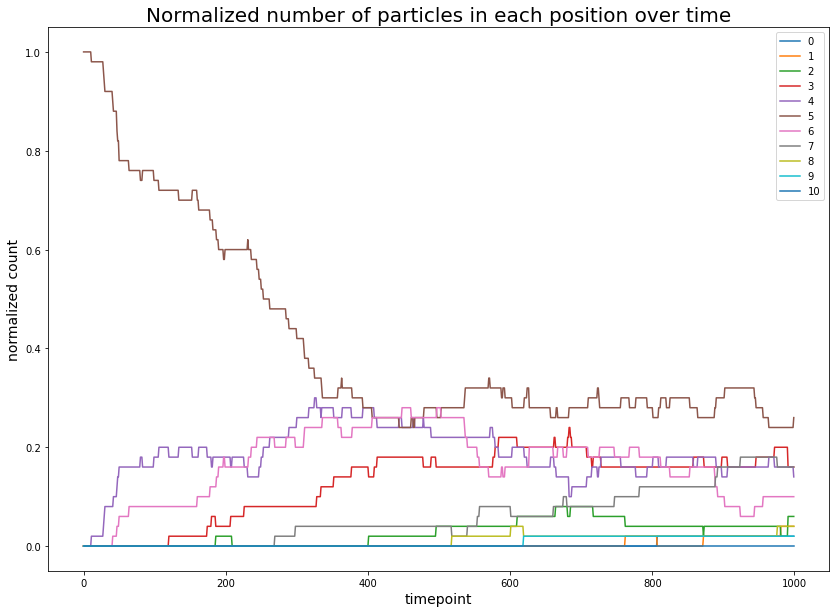

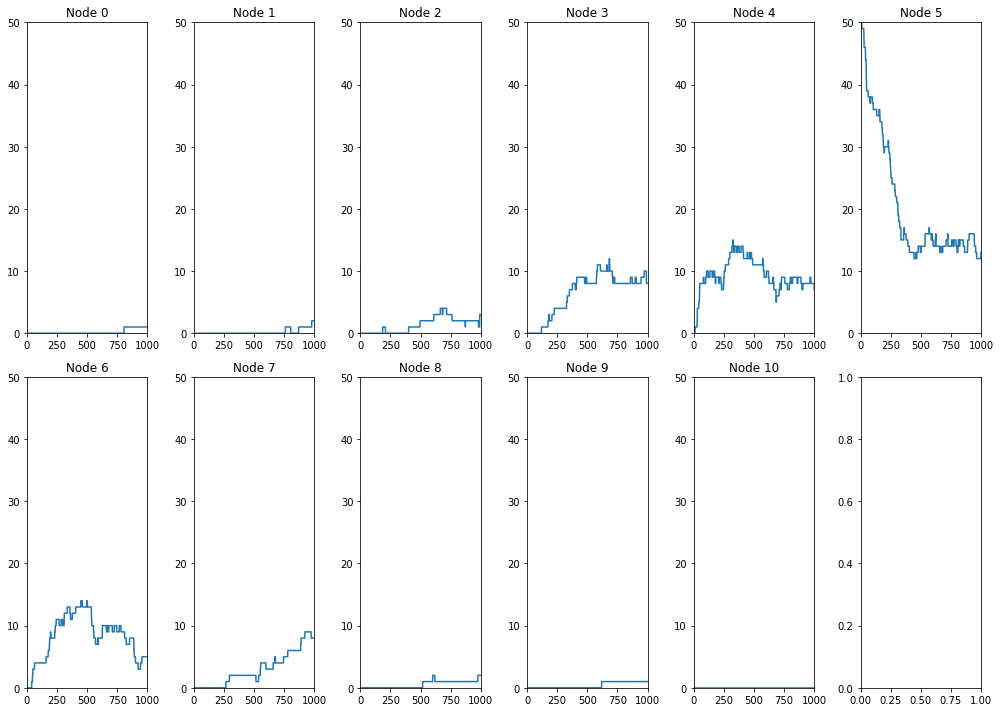

In [29]:
# plot output
unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
    particle_locs, 
    plot=True,
    plot_unnorm=True,
)

## Eigenmode Markov Model

### Transition Matrix
<div>
<img src="attachment:transition_rate.svg" width="500"/>
</div>

This uses the rate constant  $k$ as defined above:

$$k = \frac{D}{dx^2}$$

where $D$ is the diffusion constant, and $dx$ is the distance between spatial nodes.

This leads us to the transition matrix $A$:

$$ A = \begin{bmatrix} 
 -k &   k &   0 &   0 &  0 & \ldots &   0 \\
  k & -2k &   k &   0 &  0 & \ldots &   0 \\
  0 &   k & -2k &   k &  0 & \ldots &   0 \\
  0 &   0 &   k & -2k &  k & \ldots &   0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
  0 &   0 &   0 &   0 &  k &    -2k &   k \\
  0 &   0 &   0 &   0 &  0 &      k &  -k \\
\end{bmatrix}
$$

In [30]:
def transition_matrix_maker(
    diffusion_rate_constant_k: Union[int,float], 
    n_spatial_locs: int
    ) -> np.ndarray:
    """Builds and returns the transition matrix for the 1D random walk case 
    as given.

    params:
        diffusion_rate_constant_k:
            jump rate constant
        n_spatial_locs:
            number of grid points along line

    returns:
        transition matrix
    """

    # Define A (transition) matrix
    A = np.zeros(
        (n_spatial_locs, n_spatial_locs)
    )  # transition probability between grid points

    # Transition matrix is given by the ODE dynamics equation (using k-values)
    vec_diag = np.full(n_spatial_locs, (-2 * diffusion_rate_constant_k))
    vec_off_diag = np.full(
        (n_spatial_locs - 1), diffusion_rate_constant_k
    )  # off-diagonal values

    # create transition matrix
    A = (
        np.diag(vec_diag, k=0)
        + np.diag(vec_off_diag, k=1)
        + np.diag(vec_off_diag, k=-1)
    )
    A[0, 0] = -diffusion_rate_constant_k
    A[n_spatial_locs - 1, n_spatial_locs - 1] = -diffusion_rate_constant_k

    return A

array([[ 0.00166375, -0.00166375,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.00166375,  0.0033275 , -0.00166375,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.00166375,  0.0033275 , -0.00166375,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.00166375,  0.0033275 , -0.00166375,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.00166375,  0.0033275 ,
        -0.00166375,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.00166375,
         0.0033275 , -0.00166375,  0.        ,  0.        ,  0.        ,
         0.   

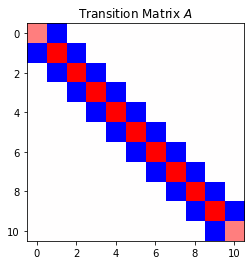

In [31]:
# find probability of moving one step
kdt, k = get_jump_probability(
    line_length, n_spatial_locs, diffusion_constant_D, dt
)

A = transition_matrix_maker(-k, n_spatial_locs)

# Use a diverging colormap
## https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging
cmap = matplotlib.cm.bwr

# Center the colormap on 0
## https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
divnorm = matplotlib.colors.TwoSlopeNorm(vcenter=0) #, vmin=-.01, vmax=.01)

plt.imshow(A, cmap=cmap, norm=divnorm)

plt.title("Transition Matrix $A$")
A

## Eigenvectors, Eigenvalues, and Eigenmodes

In [32]:
def get_eigenmode(eigenvalues, t):
    return np.exp(-eigenvalues * t)

def make_eigenmode_plots(eigenvalues):
    time = np.array(range(n_time_pts))
    alpha = 1 # transparency
    for λ in eigenvalues:
        plt.plot(
            time, 
            get_eigenmode(λ, time),
            c = 'red',
            alpha = alpha,
            label = 'λ={:.4f}'.format(λ)
        )
        
        alpha *= .66 # use transparency to generate a gradient in colors

    plt.xlabel('t [µs]')
    plt.ylabel('$e^{-λt}$')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def make_eigenvector_plots(eigenvalues, eigenvectors):

    '''
    plt.imshow(eigenvectors.transpose())
    plt.xlabel('Spatial Node')
    plt.ylabel('$v_{i, k}$')
    plt.figure()
    '''
    
    num_nodes, num_modes = eigenvectors.shape
    alpha = 1
    for k in range(num_modes):
        λ = eigenvalues[k]
        v = eigenvectors[:, k]
        #print(v)
        
        plt.plot(v, 
                 '*-', 
                 c = 'red',
                 alpha = alpha,
                 label = 'λ={:.4f}'.format(λ))
        
        alpha *= .66 # use transparency to generate a gradient in colors
        
    plt.xlabel('Spatial Node')
    plt.ylabel('Eigenvector')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    
def get_eigenvalues_and_vectors(A: np.ndarray, 
                                print_output=True, 
                                plot_eigenmodes=False,
                                plot_eigenvectors=False,
                                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the sorted eigenvalues and eigenvectors of matrix A

    Args:
        A: transition matrix

    Returns:
        eigenvalues: 1d matrix of size n_spatial_locs
        eigenvectors: 2d matrix of eigenvectors where columns
                correspond to eigenvalues (ie evec[:,k] <-> eval[k])
        eval_sort_index: argsort index array used to sort eigenvalues.
                Can be used to sort via matrix[eval_sort_index]

    """

    # get eigenvalues/eigenvectors
    # eigenmode[k] is composed of eigenvector[:, k] and eigenvalue[k]
    e_val_unsorted, e_vec_unsorted = eig(A)
    np.set_printoptions(suppress=True)  # gets rid of scientific notation
    
    # sort values and vectors
    eigenvalues = np.sort(e_val_unsorted)
    eval_sort_index = np.argsort(e_val_unsorted)
    eigenvalues[0] = round(eigenvalues[0])
    eigenvectors = e_vec_unsorted[:, eval_sort_index]
    
    # normalize eigenvector values
    eigenvectors /= eigenvectors[0, 0] #np.abs(eigenvectors[0, 0])

    if print_output:
        print("EIGENVALUES")
        print(" ", end="")
        [print(i, end=" " * 5) for i in range(n_spatial_locs)]
        print()
        print(eigenvalues.round(decimals=3))
        print()
        
        print("EIGENVECTORS")
        # eigenvector columns correspond to eigenvalues 
        # (ie evec[:,k] <-> eval[k])
        print("   ", end="")
        [print(i, end=" " * 4) for i in range(n_spatial_locs)]
        print()
        print(eigenvectors.round(decimals=1))
        print()
        
    if plot_eigenmodes:
        print("EIGENMODES (e^(-eigenvalue * t))")
        ## TODO: ADD LEGEND
        make_eigenmode_plots(eigenvalues)
        
    if plot_eigenvectors:
        print("EIGENVECTORS (over space)")
        make_eigenvector_plots(eigenvalues, eigenvectors)
    
    return eigenvalues, eigenvectors, eval_sort_index

EIGENVALUES
 0     1     2     3     4     5     6     7     8     9     10     
[0.    0.    0.001 0.001 0.002 0.003 0.004 0.005 0.006 0.006 0.007]

EIGENVECTORS
   0    1    2    3    4    5    6    7    8    9    10    
[[ 1.  -1.4 -1.4 -1.3 -1.2 -1.1  0.9 -0.8  0.6  0.4  0.2]
 [ 1.  -1.3 -0.9 -0.4  0.2  0.8 -1.2  1.4 -1.4 -1.1 -0.6]
 [ 1.  -1.1 -0.2  0.8  1.4  1.3 -0.6 -0.4  1.2  1.4  0.9]
 [ 1.  -0.8  0.6  1.4  0.9 -0.4  1.4 -1.1 -0.2 -1.3 -1.2]
 [ 1.  -0.4  1.2  1.1 -0.6 -1.4  0.2  1.3 -0.9  0.8  1.4]
 [ 1.  -0.   1.4  0.  -1.4 -0.  -1.4  0.   1.4 -0.  -1.4]
 [ 1.   0.4  1.2 -1.1 -0.6  1.4  0.2 -1.3 -0.9 -0.8  1.4]
 [ 1.   0.8  0.6 -1.4  0.9  0.4  1.4  1.1 -0.2  1.3 -1.2]
 [ 1.   1.1 -0.2 -0.8  1.4 -1.3 -0.6  0.4  1.2 -1.4  0.9]
 [ 1.   1.3 -0.9  0.4  0.2 -0.8 -1.2 -1.4 -1.4  1.1 -0.6]
 [ 1.   1.4 -1.4  1.3 -1.2  1.1  0.9  0.8  0.6 -0.4  0.2]]

EIGENMODES (e^(-eigenvalue * t))


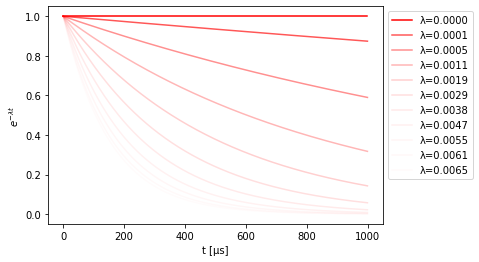

EIGENVECTORS (over space)


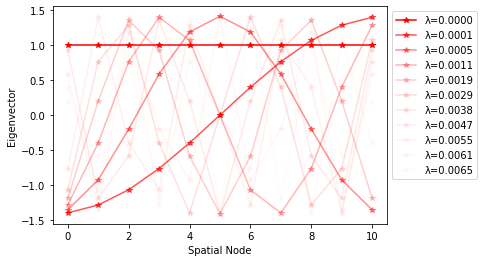

In [33]:
eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
    A,
    print_output=True, 
    plot_eigenmodes=True,
    plot_eigenvectors=True)

## Eigenmode Impulse Injection Initial Conditions

(Copy/pasting from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

If the simulation is an impulse of $N$ particles at node $x$, then the number of particles at each spatial node is zero, except for the location of the impulse injection 

### PARTICLE COUNTS

\begin{equation}
\begin{split}
    %m_{\pm k} = \frac{1}{2} \left(1 \pm \frac{\sum_i n_i \text{v}_{i k}}{\sqrt{N\sum_i n_i (\text{v}_{i k})^2}} \right) \\ % MER: Normalized version
    m_{\pm k} = \frac{1}{2} \left(\sqrt{N\sum_i n_i (\text{v}_{i k})^2} \pm \sum_i n_i \text{v}_{i k} \right) \\
    = \frac{1}{2} \left(\sqrt{N n_x (\text{v}_{x k})^2} \pm n_x \text{v}_{x k} \right) \\ 
    = \frac{1}{2} \left(\sqrt{N^2 (\text{v}_{x k})^2} \pm N \text{v}_{x k} \right)
\end{split}
\end{equation}

In [34]:
def eigenmode_init_conditions(
    eigenvectors: np.ndarray, 
    eval_sort_index: np.ndarray, 
    particle_start_loc = 5,
    print_output=True,
    plot_output=False
) -> Tuple[np.ndarray, np.ndarray]:
    
    """Find the initial normalized number of particles in the positive 
    and negative state of eigenmode k

    params:
        eigenvectors:
            eigenvector columns correspond to eigenvalues 
            (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]
        eval_sort_index:
            np.argsort(e_val_unsorted)
        particle_start_loc:
            location of impulse

    return:
        normalized number of particles in each eigenmode at time = 0
    """
    # starting loc given by particle_start_loc

    # new index of starting node location in sorted eigenvalue/vector arrays
    start_loc_eigenvalue_i = np.where(eval_sort_index == particle_start_loc)[0][0]

    # get eigenvector for starting location, all eigenmodes (v_k)
    start_loc_eigenvector = eigenvectors[start_loc_eigenvalue_i, :]

    # UNNORMALIZED SOLUTION
    n_per_positive_mode = 0.5 * (
        np.sqrt(n_particles**2 * start_loc_eigenvector**2)
        + (n_particles * start_loc_eigenvector)
        ) # *0.5
    
    n_per_negative_mode = 0.5 * (
        np.sqrt(n_particles**2 * start_loc_eigenvector**2)
        - (n_particles * start_loc_eigenvector)
        ) # *0.5

    if print_output:
        print("EIGENMODE INITIAL CONDITIONS")
        print("POSITIVE")
        print(n_per_positive_mode)
        print("NEGATIVE")
        print(n_per_negative_mode)
        print()
        
        # Also visualize the weights as an array
        # TODO: why do we need the [0]th
        all_init_modes = np.vstack(
            (n_per_positive_mode, n_per_negative_mode),
            #axis=1
        )

        plt.imshow(all_init_modes, interpolation='none')
        plt.yticks([0, 1], ['$+$', '$-$'])
        plt.xlabel('# Modes')
        plt.show()
        
    if plot_output:
        # Visualize positive and negative eigenmodes (cosines)
        # These are scaled with init coefficients
        
        fig, ax = plt.subplots(len(eigenvectors)+1, 1, 
                               figsize=(4, 12))
        alpha = 1
        
        v_qp_sum = np.zeros_like(eigenvectors[:, 0])
        v_qm_sum = np.zeros_like(v_qp_sum)
        
        for k in range(len(eigenvectors)):
            v = eigenvectors[:, k]
            
            v_qp = n_per_positive_mode[k]*v
            v_qm = n_per_negative_mode[k]*v

            ax[k].plot(
                v_qp,
                '*-',
                c='red',
                alpha=alpha
            )
            ax[k].plot(
                v_qm,
                '*-',
                c='blue',
                alpha=alpha
            )
            ax[k].set_ylim([-60, 60])
            
            v_qp_sum += v_qp
            v_qm_sum += v_qm
            
            alpha *= 0.75
            
        ax[k+1].plot(
                v_qp_sum,
                '*-',
                c='red'
        )
        ax[k+1].plot(
            v_qm_sum,
            '*-',
            c='blue'
        )

        ax[int(k/2)].set_ylabel('#Particles in $q_+$ or $q_-$')
        ax[k+1].set_ylabel('Summed')
        plt.xlabel('Spatial Node')
        plt.suptitle('Initial spin states $c_k v_k$')
        plt.tight_layout()
        plt.show()

    return n_per_positive_mode, n_per_negative_mode

In [35]:
print(eval_sort_index)
np.where(eval_sort_index == particle_start_loc)[0][0]

[ 8  9 10  7  6  5  4  3  2  1  0]


5

EIGENMODE INITIAL CONDITIONS
POSITIVE
[50.          0.         70.71067812  0.          0.          0.
  0.          0.         70.71067812  0.         -0.        ]
NEGATIVE
[ 0.          0.          0.          0.         70.71067812  0.
 70.71067812  0.          0.          0.         70.71067812]



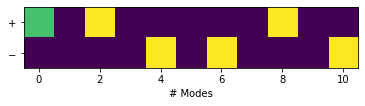

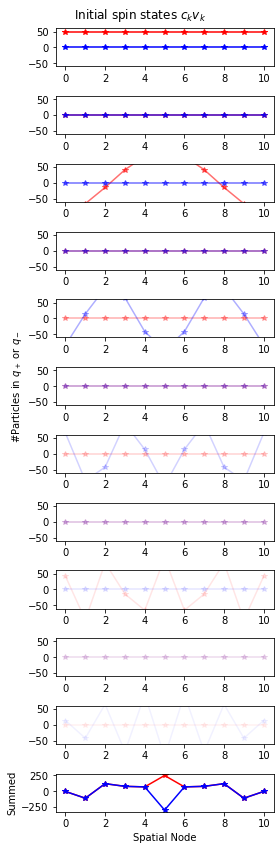

In [36]:
# Find initial values for the number of particles in each eigenmode
# For n_particles = 1, it should just be 1 and 0 respectively
init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
    eigenvectors, 
    eval_sort_index,
    particle_start_loc=5,
    print_output=True, 
    plot_output=True
)

### Transition Probability In Modal Space

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [37]:
def get_eigenmode_transition_probability(
    eigenvalues: np.ndarray, 
    print_output=True
    ) -> np.ndarray:

    transition_probability = (eigenvalues / 2) * dt

    if print_output:
        print("EIGENMODE TRANSITION PROBABILITIES")
        [print(i, end="\t") for i in range(n_spatial_locs)]
        print()
        [
            print("{:0.1e}".format(transition_probability[i]), end=" ")
            for i in range(n_spatial_locs)
        ]
        print()

    return transition_probability

In [38]:
# initialize eigenmode Markov model transition probabilities
eigenmode_transition_probability = get_eigenmode_transition_probability(
    eigenvalues, 
    print_output=True
)

EIGENMODE TRANSITION PROBABILITIES
0	1	2	3	4	5	6	7	8	9	10	
0.0e+00 6.7e-05 2.6e-04 5.7e-04 9.7e-04 1.4e-03 1.9e-03 2.4e-03 2.8e-03 3.1e-03 3.3e-03 


## Run Markov Simulation

In [39]:
def eigenmode_markov_simulation(
    n_eigenmodes: int,
    init_cond: np.ndarray,
    transition_probability: np.ndarray,
    n_particles: int,
    dt: Union[int, float],
    n_time_pts: int,
    binomial_sampling=True,
    plot=False,
    print_out = False,
    prescale=1
) -> np.ndarray:
    """Markov simulation for eigenmode analysis to capture calcium diffusion 
    over time
    
    params:
        n_eigenmodes:
            number of modes (k not +/- k); equal to number of locations 
            (n_spatial_loc)
        init_cond:
            initial distribution of particles between positive and negative 
            eigenmode states; [positive vector, negative vector]
        transition_probability:
            probability of transitioning between + and - eigenmode states
        n_particles:
            number of particles
        dt:
            timestep
        n_time_pts:
            number of timepoints

    return:
        n_per_eigenmode_state: normalized number of particles in each 
        eigenmode (+/-) at each timepoint
        np aray shape (n_modes x n_time x n_eigenmode_states)
    """
    # positive and negative states
    n_eigenmode_states = 2

    # initialize number of particles
    # n_modes x n_time x n_eigenmode_states (for +/-, this is 2)
    n_per_eigenmode_state = np.zeros(
        (n_spatial_locs, n_time_pts, n_eigenmode_states)
    ).astype("int")

    # assign initial conditions using number of molecules
    if print_out:
        print('Init Conditions')
        print('Before rounding\n', init_cond)
    # round initial conditions to nearest int
    init_cond = prescale*np.rint(init_cond) 
    if print_out:
        print('After rouding\n', init_cond)
    
    for j in range(n_eigenmode_states):
        n_per_eigenmode_state[:, 0, j] = init_cond[j]
    #print(n_per_eigenmode_state[:, 0, :])

    # for each time point
    for i in range(n_time_pts - 1):

        # for each eigenmode
        for k in range(n_spatial_locs):

            # initialize the number of particles that transition
            # [from + -> -, from - -> +]
            n_change = [0, 0]

            # find number of transitions positive/negative eigenmode state;
            for j in range(n_eigenmode_states):

                if binomial_sampling:
                    # sum number of particles that left current state given by binomial sampling
                    n_change[j] = np.random.binomial(n_per_eigenmode_state[k, i, j], transition_probability[k])
                 
                else:    
                    # sample random numbers equal to number of particles in 
                    # current state
                    r = np.random.random(n_per_eigenmode_state[k, i, j])

                    # sum number of particles that left current state
                    n_change[j] = sum(r < transition_probability[k])

            # update next time point
            for j in range(n_eigenmode_states):
                n_per_eigenmode_state[k, i + 1, j] = (
                    n_per_eigenmode_state[k, i, j]
                    - n_change[j]
                    + n_change[1 - j]
                )

    if plot:
        n_plot_columns = 2
        n_plot_rows = math.ceil(n_spatial_locs / n_plot_columns)
        fig, ax = plt.subplots(n_plot_columns, n_plot_rows, figsize=(14, 10))

        m_count = 0
        for i in range(n_plot_columns):
            for j in range(n_plot_rows):
                for k in range(n_eigenmode_states):
                    if m_count < n_spatial_locs:
                        ax[i, j].plot(
                            list(range(n_time_pts)),
                            n_per_eigenmode_state[m_count, :, k],
                        )
                        ax[i, j].set_title("Eigenmode {}".format(m_count))

                m_count += 1

        # fig.suptitle
        fig.tight_layout()
        plt.show()

    return n_per_eigenmode_state

Init Conditions
Before rounding
 [array([50.        ,  0.        , 70.71067812,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 70.71067812,  0.        ,
       -0.        ]), array([ 0.        ,  0.        ,  0.        ,  0.        , 70.71067812,
        0.        , 70.71067812,  0.        ,  0.        ,  0.        ,
       70.71067812])]
After rouding
 [[50.  0. 71.  0.  0.  0.  0.  0. 71.  0. -0.]
 [ 0.  0.  0.  0. 71.  0. 71.  0.  0.  0. 71.]]


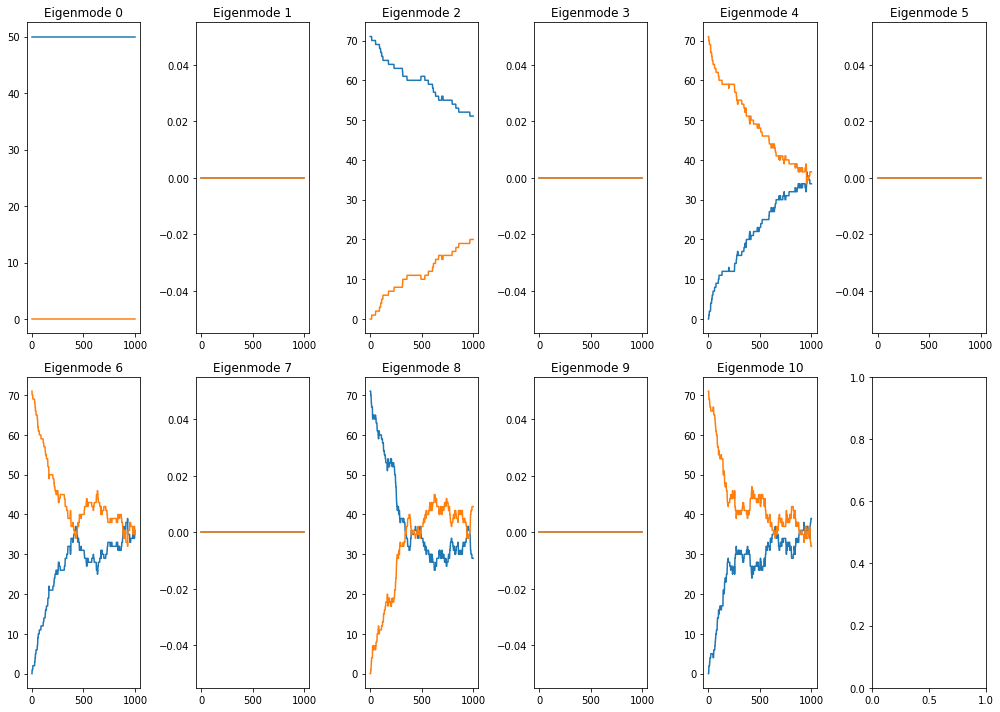

In [40]:
# run Markov model
n_per_eigenmode_state = eigenmode_markov_simulation(
    n_spatial_locs,
    [init_n_positive_modes, init_n_negative_modes],
    eigenmode_transition_probability,
    n_particles,
    dt,
    n_time_pts,
    plot=True,
    print_out=True,
)

## Inverse Transform

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [41]:
def eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state: np.ndarray, 
    eigenvectors: np.ndarray,
    postscale=1,
    print_output=True
    ) -> np.ndarray:
    
    """Calculate the number of particles at each node from the eigenmode 
    representation.

    Args:
        n_per_eigenmode_state: normalize the number of particles in each node;
        np aray shape (n_modes x n_time x n_eigenmode_states)
        eigenvectors: eigenvector of node i (vector); v[:,k] is the eigenvector
        corresponding to the eigenvalue w[k]; (ie evec[:,k] <-> eval[k])
            eigenvector[e, eigenmode (k)]


    Returns:
        np array containing normalized particle counts for each node 
        (n_nodes x n_time_pts)
    """
    
    # initialize node values (n_nodes x n_time_pts)
    node_vals_from_modes = np.zeros((n_spatial_locs, n_time_pts))
    
    # positive - negative
    n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - n_per_eigenmode_state[:,:,1])
    #n_per_eigenmode = (n_per_eigenmode_state[:,:,0] - 50*np.sqrt(2)/2) #n_per_eigenmode_state[:,:,1])
    #n_per_eigenmode = n_per_eigenmode_state[:,:,0]/np.sqrt(2) #n_per_eigenmode_state[:,:,1])
    
    '''
    MATRIX MULTIPLICATION IN PYTHON NOTES
    # np.dot usage: np.dot(a, b, out=None)
    # If a is an N-D array and b is a 1-D array, it is a sum product over the last axis of a and b.
        # v: (11, 1)
        # n_per_eigenmode, m_k: (11, 1000)
        # np.dot(v, m_k): (1, 1000)
    # If both a and b are 2-D arrays, it is matrix multiplication, but using matmul or a @ b is preferred.
        # v: (11, 11)
        # n_per_eigenmode, m_k: (11, 1000)
        # np.dot(v, m_k): (11, 1000)
    '''
    
    # for each spatial node
    for i in range(n_spatial_locs):
        node_vals_from_modes[i,:] = np.dot(eigenvectors[i,:], n_per_eigenmode) / n_spatial_locs

    if print_output:
        import math
        print("NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)")
        print("PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS")
        for i in range(n_spatial_locs):
            print(i, end="\t")
            print((node_vals_from_modes[i,0:n_time_pts:math.ceil(n_time_pts/14)]/n_particles).round(decimals=1))
        print()

    return node_vals_from_modes*postscale

In [42]:
def eigenmarkov_variance(    
    n_per_eigenmode_state: np.ndarray, 
    eigenvectors: np.ndarray,
    print_output=True
    ) -> np.ndarray:
    """TODO: Fix. Currently just copied from converting modes to nodes. Should match with equation (14), assuming 14 is right.

    Args:
        n_per_eigenmode_state (np.ndarray): _description_
        eigenvectors (np.ndarray): _description_
        print_output (bool, optional): _description_. Defaults to True.

    Returns:
        np.ndarray: _description_
    """
    
    # initialize variance (n_modes x n_time_pts)
    variance = np.zeros((n_spatial_locs, n_time_pts))
    
    # for each spatial node
    for k in range(n_spatial_locs):
        variance[:,k] = np.dot(eigenvectors[:,k]**2, n_per_eigenmode) / n_spatial_locs

In [43]:
# inverse transform; convert eigenmode representation to node representation
node_vals_from_modes = eigenmodes_to_spatial_nodes(
    n_per_eigenmode_state, 
    eigenvectors, 
    print_output=True
)

NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)
PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS
0	[-0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.  0.]
1	[-0.  -0.  -0.  -0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1  0. ]
2	[-0.   0.   0.   0.  -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.1]
3	[-0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
4	[-0.   0.1  0.1  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
5	[1.  0.8 0.6 0.6 0.4 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2]
6	[-0.   0.1  0.1  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
7	[-0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
8	[-0.   0.   0.   0.  -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.1]
9	[-0.  -0.  -0.  -0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1  0. ]
10	[-0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.  0.]



In [44]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True,
    n_particles = 50, 
    particle_start_loc = 5
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    # make subplots
    half_n_nodes = math.ceil(n1.shape[0] / 2)
    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    # normalize number of particles
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    
    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

## Main

[0.5, 2]


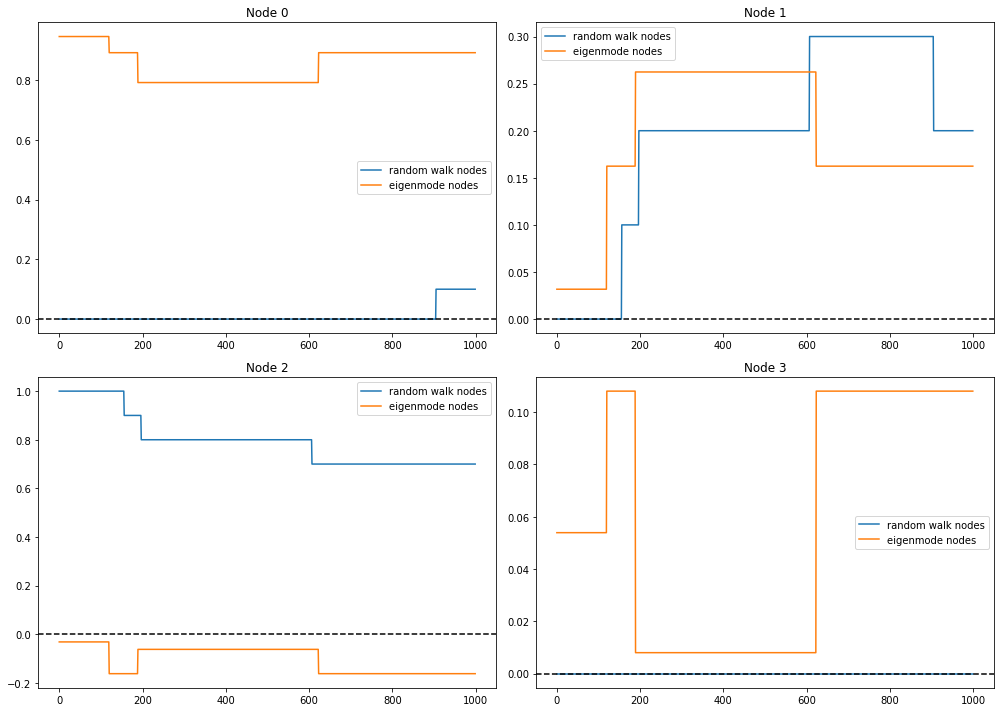

10 PARTICLES STARTED NODE 2
NORMALIZATION TURNED ON? 	 True


In [280]:
# Supply all constants as inputs (so these can be modified)

# TODO: check for latching of param values inside called functions
def main(
    n_spatial_locs = 11,    # define number of grid points along 1D line
    dt = 1,                 # time step (usec)
    n_time_pts = 1000,      # number of time points
    particle_start_loc = 5, # starting position of input impulse for molecules
    last_elem_i = -1,       # index for the last element in a list
    line_length = 4,        # total length of diffusion line (um)
    n_particles = 50,       # number of molecules
    diffusion_constant_D = 2.20e-4,  # Calcium diffusion coeff (um^2/usec)
    scale = [1, 1],
    binomial_sampling=False, # use binomial sampling for eme markov simulation
    print_eigenvalues_and_vectors = False,
    plot_eigenmodes = False,
    plot_eigenvectors = False,
    print_eigenmode_init_conditions = True,
    plot_eigenmode_init_conditions = True,
    print_eigenmode_transition_probability = False,
    plot_eigenmode_markov_simulation = True,
    print_eigenmodes_to_spatial_nodes = False,
):
    np.random.seed(42)
    # Do these need to be editable?
    min_loc = 0                   # minimum position
    max_loc = n_spatial_locs - 1  # maximum position

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, 
        n_spatial_locs, 
        diffusion_constant_D, 
        dt
    )

    # run simulation
    particle_locs = random_walk_simulation(
        n_particles, 
        n_time_pts, 
        jump_probability, 
        particle_start_loc=particle_start_loc
    )

    # plot output
    unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
        particle_locs, 
        plot=False
    )

    # build transition matrix
    A = transition_matrix_maker(-jump_rate_constant_k, n_spatial_locs)

    # get sorted eigenvalues and eigenvectors (normalized)
    eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
        A, 
        print_output=print_eigenvalues_and_vectors, 
        plot_eigenmodes=plot_eigenmodes, 
        plot_eigenvectors=plot_eigenvectors
    )

    # Find initial values for the number of particles in each eigenmode
    # For n_particles = 1, it should just be 1 and 0 respectively
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors, 
        eval_sort_index, 
        particle_start_loc, 
        print_output=print_eigenmode_init_conditions,
        plot_output=plot_eigenmode_init_conditions
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues, 
        print_output=print_eigenmode_transition_probability
    )
    
    # run Markov model
    n_per_eigenmode_state = eigenmode_markov_simulation(
        n_spatial_locs,
        [init_n_positive_modes, init_n_negative_modes],
        eigenmode_transition_probability,
        n_particles,
        dt,
        n_time_pts,
        prescale=scale[0],
        plot=plot_eigenmode_markov_simulation,
    )
    
    # inverse transform; convert eigenmode representation to node representation
    node_vals_from_modes = eigenmodes_to_spatial_nodes(
        n_per_eigenmode_state, 
        eigenvectors, 
        postscale=scale[1],
        print_output=print_eigenmodes_to_spatial_nodes)
    
    # SAVE PARTICLE COUNT OUTPUT (OPTIONAL)
    #print(n_per_eigenmode_state[:,:,0])
    #np.savetxt('n_per_pos_emode_state.txt', n_per_eigenmode_state[:,:,0], delimiter=',', fmt='%d')
    #np.savetxt('n_per_neg_emode_state.txt', n_per_eigenmode_state[:,:,1], delimiter=',', fmt='%d')
    '''
    # print('node_vals_from_modes / n_particles\n', node_vals_from_modes / n_particles)
    plt.subplot(1, 2, 1)
    plt.imshow(n_per_loc, aspect = 100, interpolation='none')
    plt.title('Random Walk')
    plt.xlabel('Time Step')
    plt.ylabel('Particles per node')
    
    plt.subplot(1, 2, 2)
    plt.imshow(node_vals_from_modes / n_particles, aspect = 100, interpolation='none')
    plt.title('Inverse Transforming\nModes to Spatial Nodes')
    plt.xlabel('Time Step')
    plt.ylabel('Particles per node (normalized)')
    plt.tight_layout()
    '''
    
    # compare with random walk simulation
    graph_num_comparison(
        unnorm_n_per_loc, 
        node_vals_from_modes,
        legend_vals=["random walk nodes", "eigenmode nodes"], 
        title="Node",
        n_particles = n_particles,
        particle_start_loc = particle_start_loc,
        normalize = True,
    )
    

def draw_impulse(n_spatial_locs, impulse_loc=5):
    '''
    just for fun
    '''
    left = impulse_loc
    right = (n_spatial_locs - impulse_loc) -1 # -1 for the impulse itself
    print('')
    print('~'*left, '.', '~'*right)
    print('_'*left, '|', '_'*right)
    print('-'*left, '|', '-'*right)
    print('='*left, '|', '='*right)
    print(' '*left, '^Impulse @ {} / {}'.format(impulse_loc, n_spatial_locs))
    
if __name__ == "__main__":
    
    # Set input params for sweeps here
    n_spatial_locs = 4
    n_particles = 10 #50
    particle_start_loc = 2
    
    for test_impulse_loc in [particle_start_loc]:#[5, 3, 7]:
        # Visualize the input condition (TODO: extend beyond impulses)
        #draw_impulse(n_spatial_locs, test_impulse_loc)
        
        # watchout for input params that might be getting latched
        tables_created = main(
            n_particles = n_particles,
            n_spatial_locs = n_spatial_locs,
            particle_start_loc = test_impulse_loc,
            scale=[1/2, 2],
            binomial_sampling=False, # use binomial sampling for eme markov simulation
            print_eigenvalues_and_vectors = False,
            plot_eigenmodes = False,
            plot_eigenvectors = False,
            print_eigenmode_init_conditions = False,
            plot_eigenmode_init_conditions = False,
            print_eigenmode_transition_probability = False,
            plot_eigenmode_markov_simulation = False,
            print_eigenmodes_to_spatial_nodes = False,
        )

### Multiple runs
Note: to run this section, set NUM_REPS below to a valide number (not zero!)

TODO: add support for sweeping params

In [46]:
# NUM_REPS = 1000
NUM_REPS = 100 # skipping statistical data collection during debug

# Make new directories by date_time for saving data (prevent overwrites)
MAKE_TIME_STAMPED_DIR = False
RUN_TYPE = 'eme-baseline'

if MAKE_TIME_STAMPED_DIR:
    from datetime import datetime
    time_now = datetime.now() # UNIX time
    time_stamp = time_now.strftime("%Y%m%d_%H%M%S")
    #print(time_stamp)
    
    import os
    if RUN_TYPE == 'rw':
        DIR_PATH_RW = r'../../data/eme-validation/random-walk/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_RW)
        print('Made new directory:', DIR_PATH_RW)
        
    elif RUN_TYPE == 'eme-baseline':
        DIR_PATH_EME = r'../../data/eme-validation/markov-eme/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_EME)
        print('Made new directory:', DIR_PATH_EME)
        
    elif RUN_TYPE == 'mcmc-eme':
        DIR_PATH_MCMC_EME = r'../../data/eme-validation/markov-mcmc-eme/{}/'.format(time_stamp) 
        os.mkdir(DIR_PATH_MCMC_EME)
        print('Made new directory:', DIR_PATH_MCMC_EME)
    else:
        print('Invalid RUN_TYPE')

#### Random walk

In [26]:
if RUN_TYPE == 'rw':
    # run random walk simulation multiple times

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, n_spatial_locs, diffusion_constant_D, dt
    )

    # run NUM_REPS times

    for i in range(NUM_REPS):
        if i%10 == 0: # print once every 10 sims
            print('RUNNING SIMULATION {}'.format(i))

        # run simulation
        particle_locs = random_walk_simulation(
            n_particles, n_time_pts, jump_probability
        )
        
        # plot output
        _, n_per_loc, _ = random_walk_postprocess(
            particle_locs, plot=False
        )

        # save output
        if MAKE_TIME_STAMPED_DIR:
            np.savetxt(DIR_PATH_RW + '/rw-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')
        else:
            np.savetxt('../../data/eme-validation/random-walk/rw-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')

#### Markov EME

In [49]:
if RUN_TYPE == 'eme-baseline' or RUN_TYPE == 'mcmc-eme':
    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length=line_length, n_spatial_locs=n_spatial_locs, diffusion_constant_D=diffusion_constant_D, dt=dt
    )

    # build transition matrix
    A = transition_matrix_maker(diffusion_rate_constant_k=-jump_rate_constant_k, n_spatial_locs=n_spatial_locs)

    # get sorted eigenvalues and eigenvectors (normalized)
    eigenvalues, eigenvectors, eval_sort_index = get_eigenvalues_and_vectors(
        A=A, print_output=False, plot_eigenmodes=False, plot_eigenvectors=False
    )

    # Find initial values for the number of particles in each eigenmode
    init_n_positive_modes, init_n_negative_modes = eigenmode_init_conditions(
        eigenvectors=eigenvectors, eval_sort_index=eval_sort_index, print_output=False
    )

    # initialize eigenmode Markov model transition probabilities
    eigenmode_transition_probability = get_eigenmode_transition_probability(
        eigenvalues=eigenvalues, print_output=False
    )

    for i in range(NUM_REPS):
        if i%2 == 0:
            print('RUNNING SIMULATION {}'.format(i))

        # run Markov model
        n_per_eigenmode_state = eigenmode_markov_simulation(
            n_eigenmodes=n_spatial_locs,
            init_cond=[init_n_positive_modes, init_n_negative_modes],
            transition_probability=eigenmode_transition_probability,
            n_particles=n_particles,
            dt=dt,
            n_time_pts=n_time_pts,
            prescale=1/(np.sqrt(2)),
            plot=False,
            binomial_sampling=(RUN_TYPE == 'mcmc-eme')
        )

        # inverse transform; convert eigenmode representation to node representation
        node_vals_from_modes = eigenmodes_to_spatial_nodes(n_per_eigenmode_state=n_per_eigenmode_state, eigenvectors=eigenvectors, postscale=(np.sqrt(2)),print_output=False) / n_particles
        
        # save output
        if MAKE_TIME_STAMPED_DIR:
            if RUN_TYPE == 'mcmc-eme':
                np.savetxt(DIR_PATH_MCMC_EME + '/mcmc-eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')
            else:
                np.savetxt(DIR_PATH_EME + '/eme-run-{}.csv'.format(f'{i:03}'), n_per_loc, delimiter=',')
        else:
            if RUN_TYPE == 'mcmc-eme':
                np.savetxt('../../data/eme-validation/markov-mcmc-eme/mcmc-eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')
            else:
                np.savetxt('../../data/eme-validation/markov-eme/eme-run-{}.csv'.format(f'{i:03}'), node_vals_from_modes, delimiter=',')

RUNNING SIMULATION 0


TypeError: eigenmode_markov_simulation() got an unexpected keyword argument 'eigenmode_transition_probability'

In [ ]:
transition_matrix_maker()
eigenmode_markov_simulation(